In [1]:
import os
import time
import json
import math
from typing import Callable
from functools import reduce
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm.callback import record_evaluation, CallbackEnv, EarlyStopException, _format_eval_result
from lightgbm.basic import _log_info
from opt_utils import *

os.system('pip install neptune-client')
os.system('pip install neptune-lightgbm')
import neptune.new as neptune
from neptune.new.integrations.lightgbm import create_booster_summary
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
NEPTUNE_API_TOKEN = user_secrets.get_secret("NEPTUNE_API_TOKEN")

# Callback for dart earlystopping
def early_stopping_dart(dart_dict: dict, stopping_rounds: int=None, model_file: str=None) -> Callable:
    """Create a callback that saves the model with the best validation score at ``model_file``, 
    and stops training if there ``stopping_rounds`` without improvement.

    Parameters
    ----------
    dart_dict : dict
        A dictionary to save the best iteration, train score, and valid score of that iteration
    stopping_rounds : int 
        The possible number of rounds without the score improving.
    model_file : str
        Path used to save the best scoring model.

    Returns
    -------
    callback : callable
        The callback that saves the best scoring model to file, and collects 
        best iteration, train score, and valid score.
    """
    
    stopping_rounds = dart_dict.get('stopping_rounds', stopping_rounds)
    model_file = dart_dict.get('model_file', model_file)
    best_score = [math.inf]
    best_iter = [0]
    
    def _callback(env: CallbackEnv) -> None:
        score = env.evaluation_result_list[-1][2]
        if score < best_score[0]: 
            best_score[0] = score
            env.model.save_model(model_file)
            dart_dict['best_iteration'] = best_iter[0] = env.iteration
            dart_dict['train_score'] = score
            dart_dict['valid_score'] = env.evaluation_result_list[1][2]
            
        if env.iteration - best_iter[0] >= stopping_rounds:
            _log_info(f"Early stopping, best iteration is:\n[{best_iter[0] + 1}]\t{best_score[0]}")
            raise EarlyStopException(best_iter[0], env.evaluation_result_list)
            
    return _callback

In [2]:
cfg = {
    "script_name": 'opt_train_dart_op_129a_not_stock_31',
    "path_features": '../input/generate-train-features-script-p13/p13_train.pkl', # Used in train mode
    "path_models": '',
    "path_data_raw": '../input/optiver-realized-volatility-prediction/',
    "neptune_project": 'chrisrichardmiles/optiver',
    "neptune_description": 'p13 encoding top columns with shake .3 using dart with custom early stopping',
    "encode_time_cols": ['real_vol_ratio_5_10', 'real_vol_std', 'real_vol_mean', 'real_vol_mean_decay_0.9_-1', 'order_norm_momentum', 'real_vol_mean_decay_0.85_-1', 'real_vol_mean_decay_0.99_1', 'real_vol_mean_decay_0.95_1', 'abs_price_wap_diff_mean_decay_flip', 'abs_price_wap_diff_mean_decay', 'order_norm_sum', 'real_vol_mean_decay_0.85_-1_2', 'spread_mean_decay_flip_95', 'real_vol_mean_decay_0.99_-1', 'real_vol_mean_decay_0.75_-1', 'spread_mean', 'order_count_sum', 'bid_price_diff_count_unique', 'spread_momentum', 'size_mean', 'real_vol_mean_decay_0.95_-1', 'order_norm_mean_decay', 'spread_2_mean_decay_95', 'order_size_mean', 'spread_mean_decay_95', 
                         'spread_pct_momentum'], 
    "encode_stock_cols": ['real_vol_ratio_5_10', 'real_vol_std', 'real_vol_mean', 'real_vol_mean_decay_0.9_-1', 'order_norm_momentum', 'real_vol_mean_decay_0.85_-1', 'real_vol_mean_decay_0.99_1', 'real_vol_mean_decay_0.95_1', 'abs_price_wap_diff_mean_decay_flip', 'abs_price_wap_diff_mean_decay', 'order_norm_sum', 'real_vol_mean_decay_0.85_-1_2', 'spread_mean_decay_flip_95', 'real_vol_mean_decay_0.99_-1', 'real_vol_mean_decay_0.75_-1', 'spread_mean', 'order_count_sum', 'bid_price_diff_count_unique', 'spread_momentum', 'size_mean', 'real_vol_mean_decay_0.95_-1', 'order_norm_mean_decay', 'spread_2_mean_decay_95', 'order_size_mean', 'spread_mean_decay_95',
                          'spread_pct_momentum'], 
    "drop_cols": ['row_id', 'time_id', 'stock_id', 'target'] + ['real_momentum_0.55_-1', 'wap_2_last-first', 'sum_bid_ask_momentum', 'abs_log_return_momentum', 'order_size_sqaure_weighted_sum', 'size_mean_decay_95', 'size_norm_momentum_95', 'size_norm_momentum', 'size_spread_mean_decay_flip_95', 'log_return_2_realized_volatility', 'abs_price_wap_diff_2_std', 'sum_bid_ask_mean', 'real_momentum_0.85_-1', 'real_vol_mean_decay_0.55_-1', 'abs_price_wap_diff_amax', 'size_mean_decay', 'real_vol_mean_decay_0.9_-1_2', 'abs_price_wap_diff_2_mean', 'real_momentum_0.65_-1_2', 'price_wap_diff_2_max_sub_min', 'real_vol_mean_decay_0.75_1', 'real_vol_min_5', 'real_vol_mean_decay_0.95_-1_2', 'real_vol_min_6', 'size_spread_mean', 'size_spread_mean_decay_95', 'real_vol_mean_decay_0.75_1_2', 'sum_bid_ask_std', 'price_wap_diff_mean_decay', 'wap_2_real_vol', 'abs_price_wap_diff_2_mean_decay', 'size_momentum_95', 'real_momentum_0.65_-1', 'size_spread_momentum_95', 'real_vol_min_2', 'sum_bid_ask_mean_decay_flip', 'real_vol_mean_decay_0.65_1', 'size_spread_mean_decay_flip', 'real_momentum_0.75_-1_2', 'abs_price_wap_diff_2_max_sub_min', 'price_wap_diff_momentum', 'real_momentum_0.55_-1_2', 'real_momentum_0.45_-1_2', 'spread_pct_std', 'abs_price_wap_diff_max_sub_min', 'real_momentum_0.95_-1', 'real_vol_min_7', 'real_vol_min_4_2', 'real_vol_mean_decay_0.99_1_2', 'spread_2_sum', 'sum_bid_ask_mean_decay', 'real_vol_mean_decay_0.55_1', 'real_vol_mean_decay_0.55_1_2', 'real_vol_mean_decay_0.9_1_2', 'real_vol_mean_decay_0.65_1_2', 'real_vol_mean_decay_0.45_1_2', 'wap_2_std', 'price_wap_diff_max_sub_min', 'real_momentum_0.85_-1_2', 'real_momentum_0.45_-1', 'price_wap_diff_2_mean_decay_flip', 'size_norm_mean_decay_flip_95', 'price_wap_diff_mean_decay_flip', 'real_momentum_0.99_-1', 'sum_bid_ask_max_sub_min', 'real_vol_mean_decay_0.95_1_2', 'real_vol_min_4', 'real_vol_min_8', 'real_vol_min_2_2', 'real_momentum_0.99_-1_2', 'real_momentum_0.95_-1_2', 'log_return_mean_decay_flip', 'real_vol_mean_decay_0.85_1_2', 'price_wap_diff_2_std', 'log_return_realized_volatility', 'abs_log_return_2_momentum', 'log_return_2_mean_decay_flip', 'log_return_std', 'log_return_2_std', 'real_momentum_0.75_-1', 'real_vol_mean_decay_0.45_-1_2', 'abs_price_wap_diff_2_momentum', 'real_momentum_0.9_-1_2', 'real_vol_mean_decay_0.9_1', 'price_wap_diff_2_mean_decay', 'real_vol_min_9_2', 'real_vol_mean_decay_0.99_-1_2', 'wap_2_max_sub_min', 'real_momentum_0.9_-1', 'dummy3', 'abs_price_wap_diff_2_mean_decay_flip', 
                                                               'abs_log_return_2_std'],
    "encode_funcs": ['mean', 'std'], 
    "shake": False, 
    "shake_std": .3, 
    "prefix": '',
    "rerun": True,
    "neptune_run_name": '',
    "lgb_params": {
        # https://lightgbm.readthedocs.io/en/latest/index.html
        "boosting_type": "dart",
        "objective": "rmse",
        "learning_rate": .05,
        "num_leaves": 255,
        "min_data_in_leaf": 255,
        "feature_fraction": 0.8,
        "bagging_fraction": .5, # Select bagging_fraction of rows every bagging_freq of iterations.
        "bagging_freq": 1,      # This speeds up training and underfits. Need both set to do anything.
        "n_estimators": 10_000,
        "early_stopping_rounds": 400,
        "n_jobs": -1,
        "seed": 42,
        "verbose": -1, 
    },
}
with open('cfg.json', 'w') as f: 
    json.dump(cfg, f)

Training fold 0


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	train's rmse: 0.00106867	train's RMSPE: 0.767499	valid's rmse: 0.00122727	valid's RMSPE: 0.708038
[2]	train's rmse: 0.001042	train's RMSPE: 0.748345	valid's rmse: 0.00119375	valid's RMSPE: 0.6887
[3]	train's rmse: 0.00101946	train's RMSPE: 0.732156	valid's rmse: 0.00116574	valid's RMSPE: 0.672537
[4]	train's rmse: 0.000995148	train's RMSPE: 0.714695	valid's rmse: 0.00113797	valid's RMSPE: 0.656516
[5]	train's rmse: 0.000973506	train's RMSPE: 0.699153	valid's rmse: 0.00111283	valid's RMSPE: 0.642014
[6]	train's rmse: 0.000949377	train's RMSPE: 0.681824	valid's rmse: 0.00108566	valid's RMSPE: 0.626337
[7]	train's rmse: 0.000948331	train's RMSPE: 0.681072	valid's rmse: 0.00108585	valid's RMSPE: 0.626448
[8]	train's rmse: 0.000927308	train's RMSPE: 0.665974	valid's rmse: 0.0010636	valid's RMSPE: 0.613614
[9]	train's rmse: 0.000907417	train's RMSPE: 0.651689	valid's rmse: 0.00104234	valid's RMSPE: 0.601345
[10]	train's rmse: 0.000908382	train's RMSPE: 0.652382	valid's rmse: 0.00104545	v

/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[66]	train's rmse: 0.000733834	train's RMSPE: 0.527025	valid's rmse: 0.000909756	valid's RMSPE: 0.524857
[67]	train's rmse: 0.000736107	train's RMSPE: 0.528657	valid's rmse: 0.000913679	valid's RMSPE: 0.527121
[68]	train's rmse: 0.000726519	train's RMSPE: 0.521771	valid's rmse: 0.000899999	valid's RMSPE: 0.519228
[69]	train's rmse: 0.000717202	train's RMSPE: 0.51508	valid's rmse: 0.000890045	valid's RMSPE: 0.513485
[70]	train's rmse: 0.000721566	train's RMSPE: 0.518214	valid's rmse: 0.000894665	valid's RMSPE: 0.516151
[71]	train's rmse: 0.000724795	train's RMSPE: 0.520533	valid's rmse: 0.000898705	valid's RMSPE: 0.518481
[72]	train's rmse: 0.00071496	train's RMSPE: 0.51347	valid's rmse: 0.000887779	valid's RMSPE: 0.512178
[73]	train's rmse: 0.000706178	train's RMSPE: 0.507163	valid's rmse: 0.000876401	valid's RMSPE: 0.505614
[74]	train's rmse: 0.000710555	train's RMSPE: 0.510306	valid's rmse: 0.000882314	valid's RMSPE: 0.509025
[75]	train's rmse: 0.000701982	train's RMSPE: 0.504149	val

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1]	train's rmse: 0.00108749	train's RMSPE: 0.758174	valid's rmse: 0.00111254	valid's RMSPE: 0.747748
[2]	train's rmse: 0.00105834	train's RMSPE: 0.73785	valid's rmse: 0.00109043	valid's RMSPE: 0.732886
[3]	train's rmse: 0.00103296	train's RMSPE: 0.720161	valid's rmse: 0.00107393	valid's RMSPE: 0.7218
[4]	train's rmse: 0.00100695	train's RMSPE: 0.702026	valid's rmse: 0.00105584	valid's RMSPE: 0.709642
[5]	train's rmse: 0.000979996	train's RMSPE: 0.683234	valid's rmse: 0.00104258	valid's RMSPE: 0.700729
[6]	train's rmse: 0.000955547	train's RMSPE: 0.666188	valid's rmse: 0.00103366	valid's RMSPE: 0.694734
[7]	train's rmse: 0.000956649	train's RMSPE: 0.666957	valid's rmse: 0.00103457	valid's RMSPE: 0.695343
[8]	train's rmse: 0.000933196	train's RMSPE: 0.650605	valid's rmse: 0.00103942	valid's RMSPE: 0.698601
[9]	train's rmse: 0.000914023	train's RMSPE: 0.637238	valid's rmse: 0.00102669	valid's RMSPE: 0.690049
[10]	train's rmse: 0.000914776	train's RMSPE: 0.637764	valid's rmse: 0.00102852	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1]	train's rmse: 0.00108958	train's RMSPE: 0.753235	valid's rmse: 0.00108864	valid's RMSPE: 0.757637
[2]	train's rmse: 0.00105938	train's RMSPE: 0.732359	valid's rmse: 0.00106573	valid's RMSPE: 0.741697
[3]	train's rmse: 0.00103442	train's RMSPE: 0.715102	valid's rmse: 0.00104278	valid's RMSPE: 0.725726
[4]	train's rmse: 0.00101025	train's RMSPE: 0.698392	valid's rmse: 0.00101601	valid's RMSPE: 0.707094
[5]	train's rmse: 0.000986894	train's RMSPE: 0.682247	valid's rmse: 0.000989767	valid's RMSPE: 0.688829
[6]	train's rmse: 0.000964	train's RMSPE: 0.66642	valid's rmse: 0.000968162	valid's RMSPE: 0.673793
[7]	train's rmse: 0.000965729	train's RMSPE: 0.667615	valid's rmse: 0.000968446	valid's RMSPE: 0.673991
[8]	train's rmse: 0.000940925	train's RMSPE: 0.650468	valid's rmse: 0.000945554	valid's RMSPE: 0.658059
[9]	train's rmse: 0.000923274	train's RMSPE: 0.638265	valid's rmse: 0.000926334	valid's RMSPE: 0.644683
[10]	train's rmse: 0.000928943	train's RMSPE: 0.642185	valid's rmse: 0.00092

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1]	train's rmse: 0.0011208	train's RMSPE: 0.737681	valid's rmse: 0.00103301	valid's RMSPE: 0.841254
[2]	train's rmse: 0.00109189	train's RMSPE: 0.718649	valid's rmse: 0.00100326	valid's RMSPE: 0.817029
[3]	train's rmse: 0.00106288	train's RMSPE: 0.699559	valid's rmse: 0.000980839	valid's RMSPE: 0.79877
[4]	train's rmse: 0.00103749	train's RMSPE: 0.682849	valid's rmse: 0.000955038	valid's RMSPE: 0.777758
[5]	train's rmse: 0.0010122	train's RMSPE: 0.666201	valid's rmse: 0.000928968	valid's RMSPE: 0.756527
[6]	train's rmse: 0.000990282	train's RMSPE: 0.651776	valid's rmse: 0.000907598	valid's RMSPE: 0.739124
[7]	train's rmse: 0.000993463	train's RMSPE: 0.65387	valid's rmse: 0.00090784	valid's RMSPE: 0.739322
[8]	train's rmse: 0.000973497	train's RMSPE: 0.640729	valid's rmse: 0.000891454	valid's RMSPE: 0.725977
[9]	train's rmse: 0.000952896	train's RMSPE: 0.627169	valid's rmse: 0.000868728	valid's RMSPE: 0.70747
[10]	train's rmse: 0.000956238	train's RMSPE: 0.629369	valid's rmse: 0.000875

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1]	train's rmse: 0.00109055	train's RMSPE: 0.757936	valid's rmse: 0.00109764	valid's RMSPE: 0.747566
[2]	train's rmse: 0.00106299	train's RMSPE: 0.738781	valid's rmse: 0.00106913	valid's RMSPE: 0.728144
[3]	train's rmse: 0.00103989	train's RMSPE: 0.722729	valid's rmse: 0.00104385	valid's RMSPE: 0.710932
[4]	train's rmse: 0.00101888	train's RMSPE: 0.708125	valid's rmse: 0.00101935	valid's RMSPE: 0.694243
[5]	train's rmse: 0.000994633	train's RMSPE: 0.691273	valid's rmse: 0.000996931	valid's RMSPE: 0.678974
[6]	train's rmse: 0.000977325	train's RMSPE: 0.679245	valid's rmse: 0.000974658	valid's RMSPE: 0.663805
[7]	train's rmse: 0.000976785	train's RMSPE: 0.678869	valid's rmse: 0.000974485	valid's RMSPE: 0.663687
[8]	train's rmse: 0.000956633	train's RMSPE: 0.664863	valid's rmse: 0.000955151	valid's RMSPE: 0.650519
[9]	train's rmse: 0.00093296	train's RMSPE: 0.64841	valid's rmse: 0.000933871	valid's RMSPE: 0.636026
[10]	train's rmse: 0.000934559	train's RMSPE: 0.649522	valid's rmse: 0.000

Waiting for the remaining 13718 operations to synchronize with Neptune. Do not kill this process.


All 13718 operations synced, thanks for waiting!
retraining model with all data for [576, 22, 269, 189, 355] iterations


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


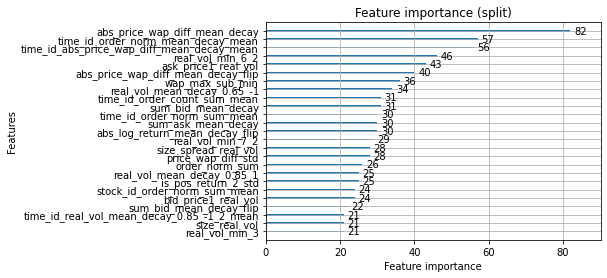

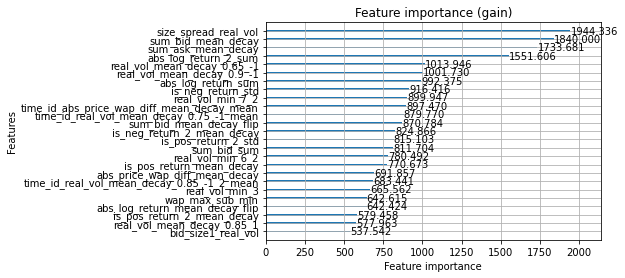

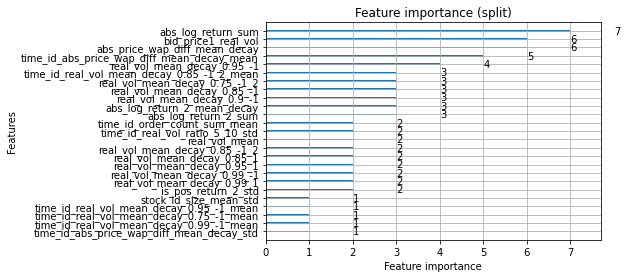

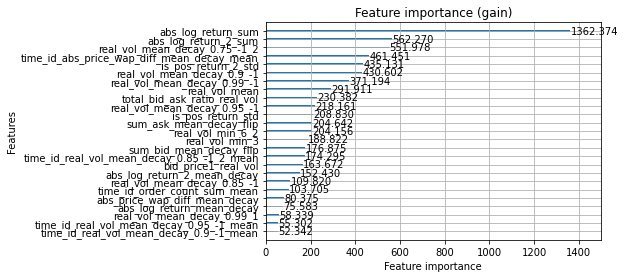

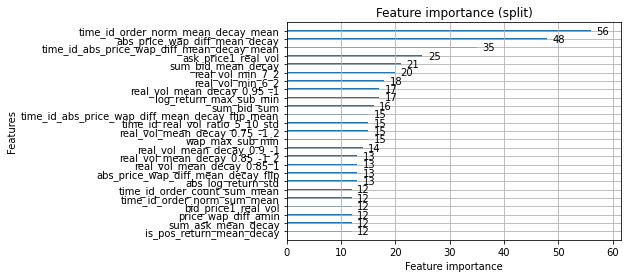

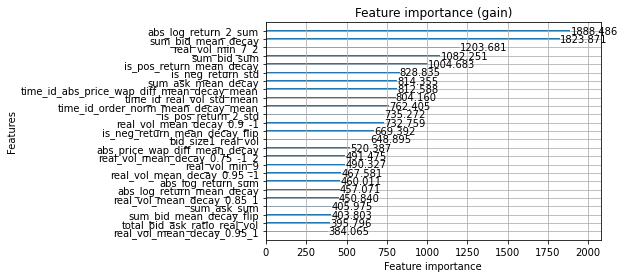

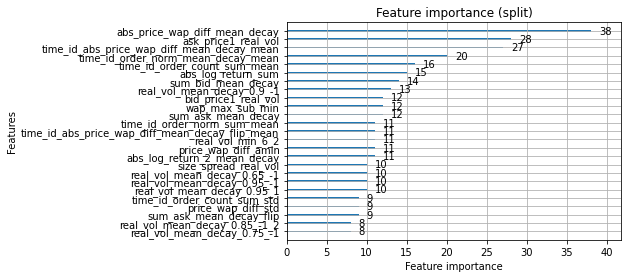

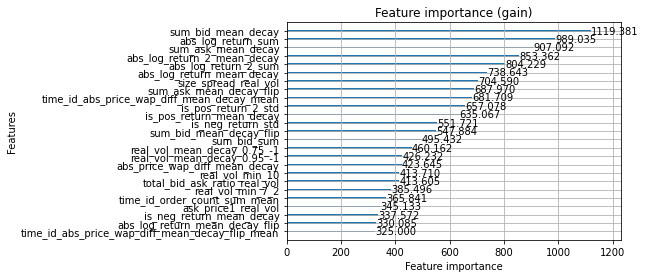

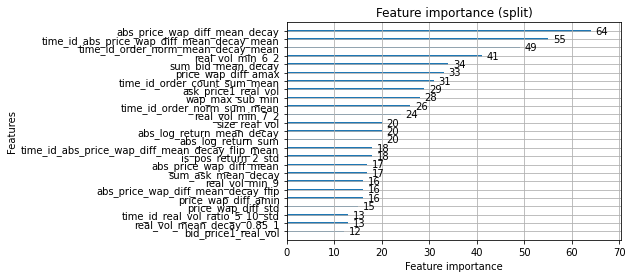

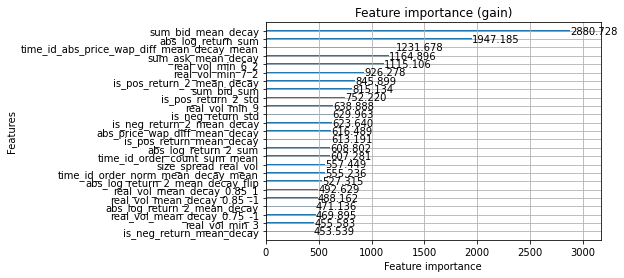

In [3]:
def main(): 
    train = pd.read_pickle(cfg['path_features'])
    train['real_vol_ratio_5_10'] = train[[f'real_vol_min_{i}' for i in range(1, 6)]].sum(axis=1) / train[[f'real_vol_min_{i}' for i in range(6, 11)]].sum(axis=1)
    train['real_vol_std'] = train[[f'real_vol_min_{i}' for i in range(1, 11)]].std(axis=1)
    train['real_vol_mean'] = train[[f'real_vol_min_{i}' for i in range(1, 11)]].mean(axis=1)
    train = encode_cols(train, cfg["encode_time_cols"], funcs=cfg['encode_funcs'], on='time_id')

    # Saving encoded stock columns
    feat_file = 'enc_' + os.path.split(cfg['path_features'])[1]
    tmp = encode_cols(train, cfg["encode_stock_cols"], funcs=cfg['encode_funcs'], on='stock_id')
    tmp.to_pickle(os.path.join(cfg['path_models'], feat_file))
    del tmp

    drop_cols = [c for c in cfg['drop_cols'] if c in train.columns and c != 'stock_id']
    x = train.drop(drop_cols, axis = 1)
    y = train['target']

    oof_predictions = np.zeros(x.shape[0]) # Create out of folds array
    scores = [] # Keep track of scores for each fold and all oof at the end
    best_iterations = []
    training_best_scores = []
    valid_best_scores = [] # Same as scores in this script, but would be different with nested cv
    best_score_diffs = []
    dict_eval_logs = [] # For experimentation tracking
    booster_summaries = [] # For experimentation tracking
    dumb_features = []
    top_features = []

    for fold in range(5):
        
        trn_ind = x.fold != fold
        val_ind = x.fold == fold

        print(f'Training fold {fold}')
        x_train, x_val = x[trn_ind].drop('fold', axis=1), x[val_ind].drop('fold', axis=1)
        y_train, y_val = y[trn_ind], y[val_ind]
        tmp = np.zeros(x_val.shape[0])
        
        train_mask = x_train.stock_id == 31
        val_mask = x_val.stock_id == 31

        x_train = encode_cols(x_train, 
                              cfg['encode_stock_cols'], 
                              funcs=cfg['encode_funcs'], 
                              shake=cfg['shake'], 
                              shake_std=cfg['shake_std']).drop('stock_id', axis=1)
        n_train_cols = x_train.shape[1]

        x_val = encode_cols(x_val, 
                            cfg['encode_stock_cols'], 
                            funcs=cfg['encode_funcs']).drop('stock_id', axis=1)
        
        x_train, y_train = x_train[train_mask], y_train[train_mask]
        x_val, y_val = x_val[val_mask], y_val[val_mask]

        train_weights = 1 / np.square(y_train) # Root mean squared percentage error weights
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight=train_weights, free_raw_data=False)
        val_dataset = lgb.Dataset(x_val, y_val, weight=val_weights, reference=train_dataset, free_raw_data=False)

        # Variables for callback functions
        
        model_file = os.path.join(cfg['path_models'], f'{cfg["prefix"]}lgb_fold_{fold}.txt')
        dart_dict = {'stopping_rounds': cfg['lgb_params']['early_stopping_rounds'],
                     'model_file': model_file}
        dict_eval_log = {}
        

        model = lgb.train(params = cfg['lgb_params'], 
                          train_set = train_dataset, 
                          valid_sets = [val_dataset, train_dataset], 
                          valid_names = ['valid', 'train'], 
                          feval = feval_rmspe,
                          callbacks=[record_evaluation(dict_eval_log), 
                                     early_stopping_dart(dart_dict)],
                          verbose_eval = 1)

        model = lgb.Booster(model_file=model_file)
        y_pred = model.predict(x_val)
        tmp[val_mask] = y_pred
        oof_predictions[val_ind] = tmp
        scores.append(round(rmspe(y_val, y_pred), 3))

        dumb_features.append(get_dumb_features(model))
        top_features.append(get_top_features(model))

        booster_summary = create_booster_summary(
            booster=model,
            log_importances=True,
            max_num_features=25,
            log_trees_as_dataframe=False, 
            log_pickled_booster=True, 
            y_true=y_val, 
            y_pred=y_pred, 
        )
        
        train_score = dart_dict['train_score']
        valid_score = dart_dict['valid_score']
        print(dart_dict['best_iteration'])
        best_iterations.append(dart_dict['best_iteration'])
        training_best_scores.append(round(train_score, 3))
        valid_best_scores.append(round(valid_score, 3))
        best_score_diffs.append(round(valid_score - train_score, 3))

        booster_summaries.append(booster_summary)
        dict_eval_logs.append(dict_eval_log)
        del booster_summary, dict_eval_log

    rmspe_score = round(rmspe(y, oof_predictions), 4)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    print(f'Our cv fold scores are {scores}')
    np.save('oof_predictions', oof_predictions)

    run = neptune.init(
            project=cfg['neptune_project'],
            api_token=NEPTUNE_API_TOKEN,
            name=cfg['neptune_run_name'],    
            description=cfg['neptune_description'],
            tags=[cfg['path_features'], cfg['prefix']],
            source_files=['cfg.json'],
    )
    run['feat_id'] = feat_file
    run['cfg'] = cfg
    run['RMSPE'] = rmspe_score
    run['RMSPE_oof_scores'] = scores
    run['RMSPE_cv_std'] = np.std(scores)

    run['best_iterations'] = best_iterations
    best_iterations_mean = int(np.mean(best_iterations))
    run['best_iterations_mean'] = best_iterations_mean
    run['training_best_scores'] = training_best_scores
    run['valid_best_scores'] = valid_best_scores
    run['best_score_diffs'] = best_score_diffs
    run['best_score_diffs_mean'] = round(np.mean(best_score_diffs), 3)
    run['dumb_features'] = list(reduce(lambda a, b: set(a).intersection(set(b)), dumb_features))
    run['top_features'] = list(reduce(lambda a, b: set(a).intersection(set(b)), top_features))

    # Logs for each folds model
    for fold in range(5):
        run[f'lgbm_summaries/fold_{fold}'] = booster_summaries[fold]
        run[f'lgbm_summaries/dumb_features_{fold}'] = list(dumb_features[fold])
        run[f'lgbm_summaries/top_features_{fold}'] = list(top_features[fold])
        dict_eval_log = dict_eval_logs[fold]
        for valid_set, odict in dict_eval_log.items():
            for metric, log in odict.items():
                for val in log:
                    run[f'eval_logs/{fold}_{valid_set}_{metric}'].log(val)
    run.stop()

    if cfg['rerun']: 
        print(f'retraining model with all data for {best_iterations} iterations')
        params = cfg['lgb_params'].copy()
        params['early_stopping_rounds'] = 0 # No valid set to stop with

        x_train = x.drop(['fold'], axis=1)
        x_train = encode_cols(x_train, 
                              cfg['encode_stock_cols'], 
                              funcs=cfg['encode_funcs'], 
                              shake=cfg['shake'], 
                              shake_std=cfg['shake_std']).drop('stock_id', axis=1)
        y_train = y

        assert(n_train_cols == x_train.shape[1])

        train_weights = 1 / np.square(y_train) # Root mean squared percentage error weights
        train_dataset = lgb.Dataset(x_train, y_train, weight=train_weights)

        for fold, best_iter in enumerate(best_iterations): 
            params['n_estimators'] = int(best_iter) # lgbm needs int here
            model = lgb.train(params = params, 
                              train_set = train_dataset)
            model.save_model(os.path.join(cfg['path_models'], f'{cfg["prefix"]}rerun_lgb_{fold}.txt'))
    
if __name__ == '__main__': 
    main()

In [4]:
m = lgb.Booster(model_file='./lgb_fold_0.txt')